### Task 4: Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems.

### 1. Imports
Let's first import all the libraries that required to perform this task.

In [1]:
import cv2
import os
import warnings
import tensorflow as tf
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from random import shuffle
from zipfile import ZipFile
from PIL import Image
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau


%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 2. Load the dataset

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0153.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0105.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0018.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0050.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0029.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0195.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0051.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0074.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0142.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0149.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0121.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0194.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0003.png
/kaggl

### 3. Data Analysis and Preprocessing
Let's prepare and analyze our dataset.

#### Exploring images of dataset
Let's see what kind of images does the dataset provide and see what kind of preprocessing needs to be done. 

In [3]:
lookup = dict()
reverselookup = dict()
count = 0

for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1

x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0

for i in range(0, 10):
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'):
            count = 0
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/'):
                path = '../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr)
                count = count + 1

            y_values = np.full((count, 1), lookup[j])
            y_data.append(y_values)
            datacount = datacount + count

x_data = np.array(x_data, dtype='float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1)

In [4]:
# Print total number of files in each folder
for i in range(10):  # Loop over the ten top-level folders
    folder_path = f'../input/leapgestrecog/leapGestRecog/0{i}/'
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
    print(f"Total files in {folder_path}: {total_files}")

Total files in ../input/leapgestrecog/leapGestRecog/00/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/01/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/02/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/03/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/04/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/05/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/06/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/07/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/08/: 2000
Total files in ../input/leapgestrecog/leapGestRecog/09/: 2000


In [5]:
x_data.shape

(20000, 150, 150)

In [6]:
y_data.shape

(20000, 1)

In [7]:
reverselookup

{0: '02_l',
 1: '04_fist_moved',
 2: '09_c',
 3: '10_down',
 4: '06_index',
 5: '08_palm_moved',
 6: '07_ok',
 7: '05_thumb',
 8: '01_palm',
 9: '03_fist'}

**Visualize random samples from the dataset**

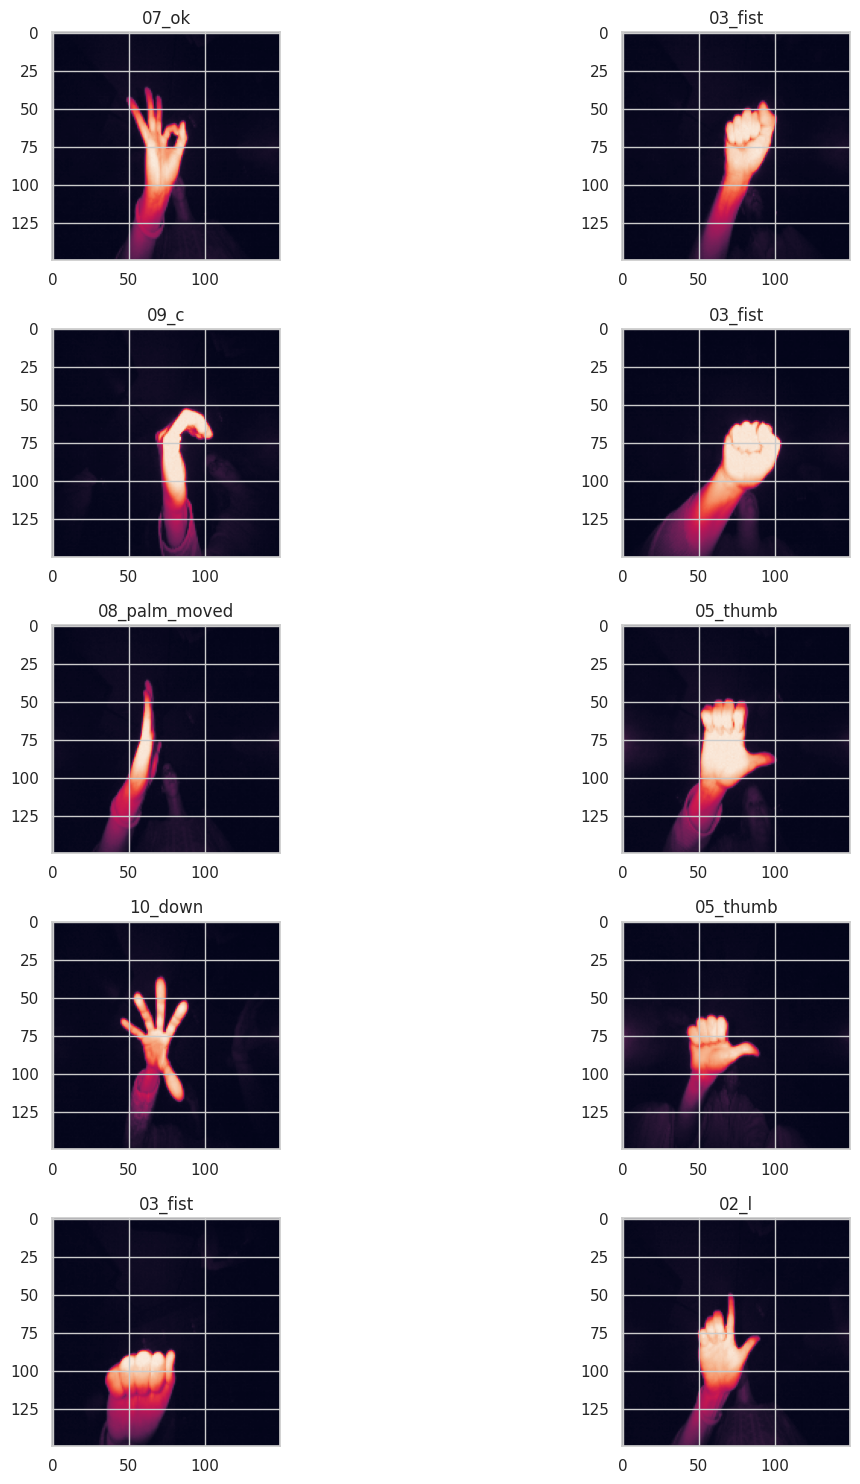

In [8]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(2):
        l = rn.randint(0, len(y_data))
        ax[i, j].imshow(x_data[l])
        ax[i, j].set_title(reverselookup[y_data[l, 0]])

plt.tight_layout()

**Preprocess the data and split into training and testing sets**

In [9]:
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [10]:
print(x_data.shape)
print(y_data.shape)

(20000, 150, 150, 1)
(20000, 1)


In [11]:
X_train,X_test, y_train,y_test=train_test_split(x_data, y_data, test_size=0.25, random_state=42)

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15000, 150, 150, 1)
(15000, 1)
(5000, 150, 150, 1)
(5000, 1)


### 4. Model building and training
Now let's finally build our model! We'll do this using CNN and feedforward NN.

In [13]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(10, activation = "softmax"))

**Set Up Training Parameters And Callbacks**

In [14]:
BATCH_SIZE = 128
EPOCHS = 15

In [15]:
CHECKPOINT = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
EARLYSTOP = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
TENSORBOARD = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

CSVLOGGER = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

REDUCE = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [CHECKPOINT,TENSORBOARD,CSVLOGGER,REDUCE,EARLYSTOP]

**Compile The Model And Display Model Summary**

In [16]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

**Train the model**

In [18]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks)


Epoch 1/15
118/118 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8868
Epoch 1: val_loss improved from inf to 0.01104, saving model to ./base.model
118/118 [==============================] - 19s 107ms/step - loss: 0.3386 - accuracy: 0.8868 - val_loss: 0.0110 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 2/15
117/118 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9972
Epoch 2: val_loss improved from 0.01104 to 0.00203, saving model to ./base.model
118/118 [==============================] - 11s 92ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.0020 - val_accuracy: 0.9996 - lr: 0.0010
Epoch 3/15
117/118 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9981
Epoch 3: val_loss did not improve from 0.00203
118/118 [==============================] - 9s 80ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0224 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 4/15
117/118 [============================>.] - ETA: 0s - loss:

**Training and Validation Graph**

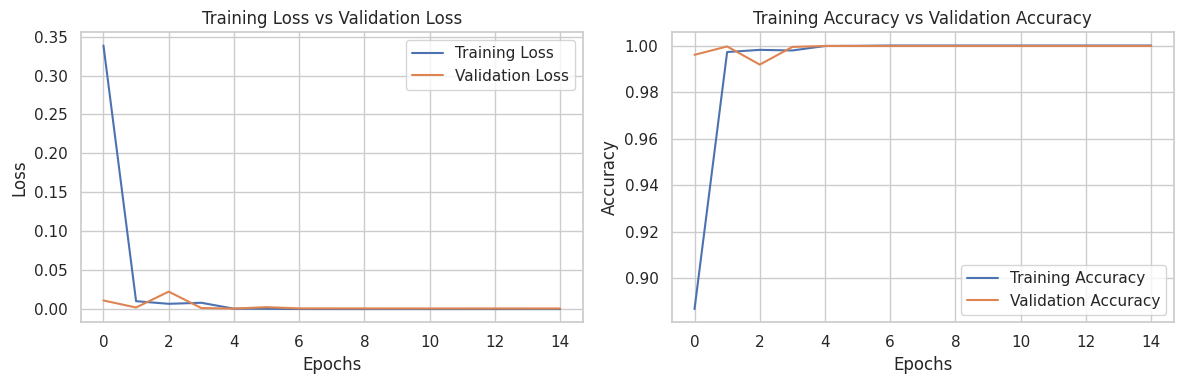

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 5. Model Evaluation
Now let's use our trained model to generate predictions for our data and see how it does.

In [20]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)
print(y_test.shape)
print(classification_report(y_test, y_pred))

157/157 [==============================] - 1s 6ms/step
(5000,)
(5000, 1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      1.00      1.00       511
           2       1.00      1.00      1.00       503
           3       1.00      1.00      1.00       508
           4       1.00      1.00      1.00       466
           5       1.00      1.00      1.00       490
           6       1.00      1.00      1.00       499
           7       1.00      1.00      1.00       502
           8       1.00      1.00      1.00       518
           9       1.00      1.00      1.00       485

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [21]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[518   0   0   0   0   0   0   0   0   0]
 [  0 511   0   0   0   0   0   0   0   0]
 [  0   0 503   0   0   0   0   0   0   0]
 [  0   0   0 508   0   0   0   0   0   0]
 [  0   0   0   0 466   0   0   0   0   0]
 [  0   0   0   0   0 490   0   0   0   0]
 [  0   0   0   0   0   0 499   0   0   0]
 [  0   0   0   0   0   0   0 501   0   1]
 [  0   0   0   0   0   0   0   0 518   0]
 [  0   0   0   0   0   0   0   0   0 485]]


In [22]:
def make_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


    model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))

    model.add(Dense(10, activation = "softmax"))
    
    return model

In [23]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
k = 5

# Split the data into k folds.
# Use StratifiedKflow to ensure number of samples in each fold is proportional to the number of samples in the class
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [28]:
%%time
model_folder = "./"

# Initialize a list to store the model accuracies
accuracies = []
fold = 0
# Iterate over the folds
for train_index, test_index in kfold.split(x_data, y_data):
    fold+=1
    print(f"Fold {fold}")
    # Create a new instance of the model for each fold. No need to delete model????
    model = make_model()
    
    # Compile the model
    model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    # Get the summary of model
    model.summary()

    # Train the model on the training data
    model.fit(x_data[train_index], y_data[train_index], epochs=EPOCHS, callbacks=callbacks, batch_size=BATCH_SIZE, verbose=1)

    # Evaluate the model on the test data
    _, accuracy = model.evaluate(x_data[test_index], y_data[test_index], verbose=0)
    accuracies.append(accuracy)

    # Evaluate the model in depth using confusion_matrix and classification_report
    y_pred = model.predict(x_data[test_index])
    y_pred_class = y_pred.argmax(axis=-1)
    print(confusion_matrix(y_data[test_index], y_pred_class))
    print(classification_report(y_data[test_index], y_pred_class, digits=4))

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"Average accuracy: {average_accuracy}")

Fold 1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 18, 18, 96)

**Visualizing Predictions**

1/1 [==============================] - 0s 105ms/step


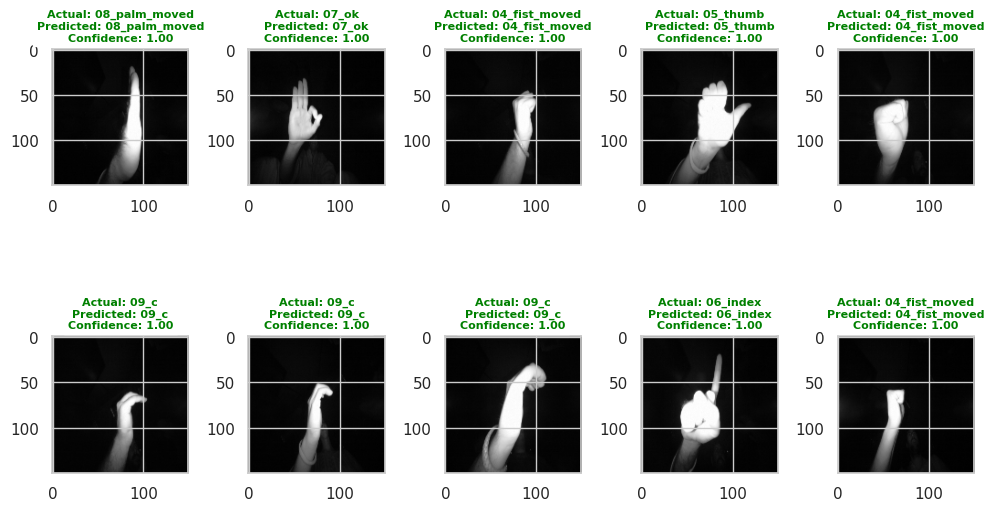

In [29]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Assuming you have a function to reverse lookup the class indices
def reverse_lookup(index):
    return reverselookup[index]

# Select random samples from the test set
num_samples_to_visualize = 10
random_indices = random.sample(range(len(X_test)), num_samples_to_visualize)
x_random_samples = X_test[random_indices]
y_random_labels = y_test[random_indices]  # Assuming y_test contains the true labels

# Make predictions on the randomly selected test samples
predictions_random = model.predict(x_random_samples)

# Visualize predictions for the randomly selected test samples in 2 rows
num_rows = 2
num_cols = num_samples_to_visualize // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        # Plot the original image
        axes[i, j].imshow(x_random_samples[index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

        # Print the confidence score in bold black color
        predicted_class = np.argmax(predictions_random[index])
        actual_class = y_random_labels[index][0]
        confidence_score = predictions_random[index][predicted_class]

        title_color = 'green' if predicted_class == actual_class else 'red'
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nPredicted: {reverse_lookup(predicted_class)}\nConfidence: {confidence_score:.2f}', color=title_color, backgroundcolor='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


### 6. Model Saving
Lets save our model, so that we can deploy it in the future.

In [30]:
model.save("hand_gesture.h5")

In [31]:
model = tf.keras.models.load_model('hand_gesture.h5')

### 7. Conclusion
In conclusion, it is found that, we successfully did all the steps from loading dataset to model saving that are required in order to develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems and found testing accuracy of 99%.